In [1]:
%load_ext autoreload
%autoreload 2 

* 이미지를 VAE로 Embedding하여 얻은 vector의 similarity와 풍속데이터의 Similarity 비교
* 체크해야 할 것
    - 풍속기록이 있는 데이터만 필요하며, 일부는 Train 일부는 test 이를 구분해야 할 필요가 있음

In [15]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict

import yaml
import torch
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, DataLoader, TensorDataset

from models import *
from src import *

In [16]:
# Wind data load

with open('data/_Main_dataset.pickle', 'rb') as f:
    windspeed_dataset = pickle.load(f)
    
station_list = list(windspeed_dataset.keys())
windspeed_list = []
for item in windspeed_dataset.values():
    windspeed_list.append(item[3])
windspeed_list = np.array(windspeed_list)

In [17]:
# load config
config_path = 'configs/betatc_vae_sate.yaml'
checkpoint_path = 'logs/BetaTCVAE/epoch=499.ckpt'

with open(config_path, 'rb') as f:
    config = yaml.safe_load(f)

#load vae model
model = vae_models[config['model_params']['name']](**config['model_params'])
untrained_model = vae_models[config['model_params']['name']](**config['model_params'])

#checkpoint load
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu')) # when using CPU
new_state_dict = OrderedDict()
for k, v in checkpoint['state_dict'].items():
    name = k[6:]
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [18]:
# load img data

IMG_PATH = '../../Share_Data/satellite/jpg_hill_d10/jpg_tif_d10/{}az0.jpg'

img_list =[ ]
label_list = []
for station_code in station_list:
    img = Image.open(IMG_PATH.format(station_code)).resize([config['exp_params']['img_size']]*2)
    img_list.append(np.array(img))
    label_list.append(station_code)

img_list = np.expand_dims((np.array(img_list)/255.)*2-1, axis=1)
tensor_img = torch.Tensor(img_list)
tensor_dataset = TensorDataset(tensor_img)
dataloader = DataLoader(tensor_img)

In [78]:
x, y, mu, log_var, z = model.forward(tensor_img)
_, _, untrained_mu, untrained_log_var, untrained_z = untrained_model.forward(tensor_img)

print('size of latent vector, z : {}'.format(z.size()))

size of latent vector, z : torch.Size([349, 10])


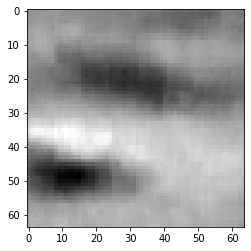

In [99]:
plt.imshow(x[54][0].detach().numpy(), cmap='gray')

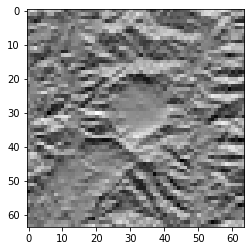

In [100]:
plt.imshow(y[54][0].detach().numpy(), cmap='gray')

### Analysis

In [20]:
#windspeed difference matrix

windspeed_diff_list = []
for i in windspeed_list:
    temp_list = []
    for j in windspeed_list:
        temp_list.append(abs(i-j))
    windspeed_diff_list.append(temp_list)
windspeed_diff_list = np.array(windspeed_diff_list)

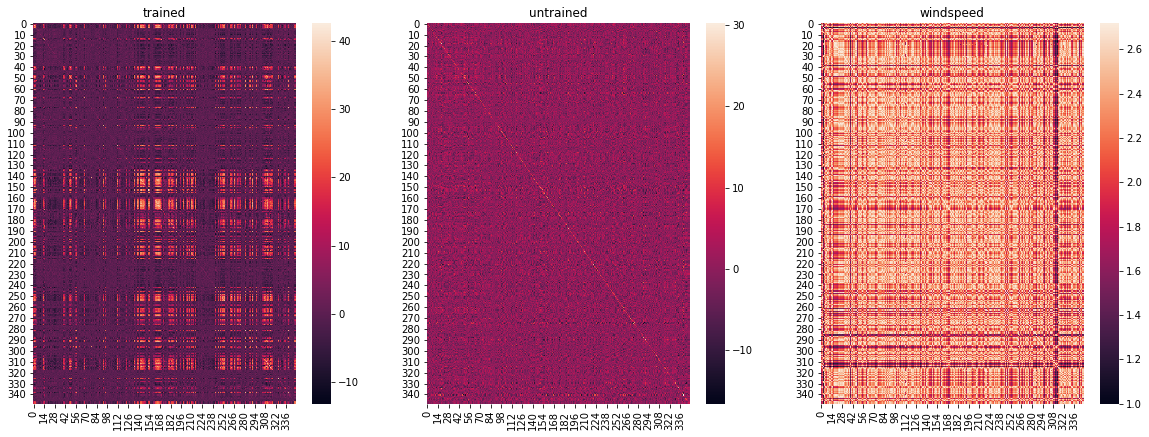

In [21]:
cov = torch.mm(z, z.t().contiguous())
untrained_cov = torch.mm(untrained_z, untrained_z.t().contiguous())

windspeed_diff = np.exp(-windspeed_diff_list/windspeed_diff_list.max()+1)


plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained')
sns.heatmap(cov.detach().numpy())

plt.subplot(1,3,2)
plt.title('untrained')
sns.heatmap(untrained_cov.detach().numpy())

plt.subplot(1,3,3)
plt.title('windspeed')
sns.heatmap(windspeed_diff)
plt.show()

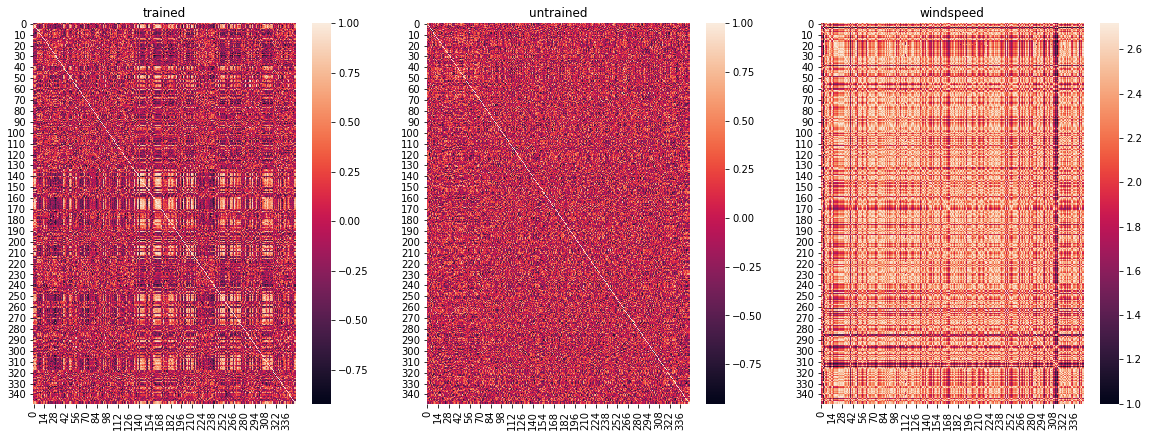

In [22]:
z_n = z.norm(dim=1)[:,None]
z_n = torch.max(z_n, 1e-8*torch.ones_like(z_n))

untrained_z_n = untrained_z.norm(dim=1)[:,None]
untrained_z_n = torch.max(untrained_z_n, 1e-8*torch.ones_like(untrained_z_n))

cov = torch.mm(z/z_n, (z/z_n).t().contiguous())
untrained_cov = torch.mm(untrained_z/untrained_z_n, (untrained_z/untrained_z_n).t().contiguous())

windspeed_diff = np.exp(-windspeed_diff_list/windspeed_diff_list.max()+1)


plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained')
sns.heatmap(cov.detach().numpy())

plt.subplot(1,3,2)
plt.title('untrained')
sns.heatmap(untrained_cov.detach().numpy())

plt.subplot(1,3,3)
plt.title('windspeed')
sns.heatmap(windspeed_diff)
plt.show()

### Report 1
* 66번 인덱스와 39번 인덱스 차이 비교|

In [36]:
a_index = 66
b_index = 39

In [48]:
# z list
select_value = []
select_value.append(z[a_index].detach().numpy())
select_value.append(z[b_index].detach().numpy())

# origin
img_a = img_list[a_index][0]
img_b = img_list[b_index][0]

# recons 
recons_img_a = model.decode(z[a_index]).detach().numpy()[0][0]
recons_img_b = model.decode(z[b_index]).detach().numpy()[0][0]

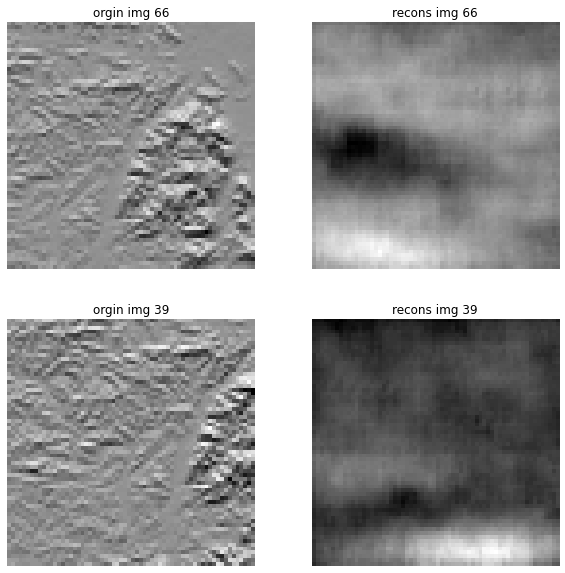

In [47]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(img_a, cmap='gray')
plt.title('orgin img {}'.format(a_index))
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(recons_img_a, cmap='gray')
plt.title('recons img {}'.format(a_index))
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(img_b, cmap='gray')
plt.title('orgin img {}'.format(b_index))
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(recons_img_b, cmap='gray')
plt.title('recons img {}'.format(b_index))
plt.axis('off')

plt.show()

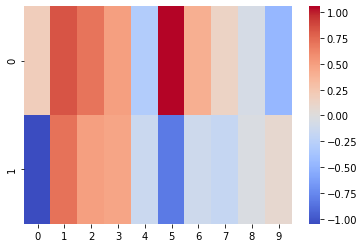

In [27]:
sns.heatmap(select_value, cmap='coolwarm')
plt.show()